# June, 19th, 2021

**Motivation**: Clean up code even more, and write new modules to compactify stuff.  Embedded you will find:

- **ROI** definition on cortex
- n=4 and n=14 **hierarchical clusters**
- Some streamlines from tract tracing data for **RSP**, **ORB**, and **SS**

</br>

In [1]:
# HIDE CODE


import os
import sys
import ants
import nrrd
import collections
import numpy as np
import pandas as pd
import nibabel as nib
import networkx as nx
import operator as op
from rich import print
from pathlib import Path
from pprint import pprint
from tqdm.notebook import tqdm
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import IFrame, display
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')

# GitHub
sys.path.insert(0, pjoin(git_dir, 'Ca-fMRI'))
from analysis.network import *
from utils.plotting import *
from utils.render import *
from model.mouse import Mice

# Allen
allen_ws = pjoin(os.environ['HOME'], 'Documents/workspaces/allen')
allen_path = pjoin(allen_ws, 'MouseConnectivity')
os.makedirs(allen_path, exist_ok=True)
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def trim_axs(axes, n):
    axs = axes.flat
    for ax in axs[n:]:
        ax.remove()
    return axs[:n]


def reset_ants_img(img: Union[np.ndarray, ants.ANTsImage], dtype=float, origin=0.0, spacing=1.0):
    ndims = len(img.shape)
    if isinstance(img, ants.ANTsImage):
        img = img.numpy()
    return ants.from_numpy(img.astype(dtype), origin=[origin]*ndims, spacing=[spacing]*ndims)


def add_children(graph: nx.DiGraph(), src_id: int, level: int, structure_tree):
    src = structure_tree.get_structures_by_id([src_id])[0]
    children = structure_tree.children([src_id])[0]
    for child in children:
        src_name = '\n'.join(src['name'].split(' '))
        tgt_name = '\n'.join(child['name'].split(' '))
        graph.add_node(tgt_name, lvl=level)
        graph.add_edge(src_name, tgt_name)
    return graph, children


def make_tree_graph(root: str, mcc: MouseConnectivityCache, n_levels: int = 3):
    structure_tree = mcc.get_structure_tree()
    structure = structure_tree.get_structures_by_name([root])[0]
    
    g = nx.DiGraph()
    g.add_node('\n'.join(structure['name'].split(' ')), lvl=0)

    dend = {}
    for lvl in range(n_levels):
        if lvl == 0:
            src_ids = [structure['id']]
        else:
            new_leaves = []
            for i in src_ids:
                g, children = add_children(
                    graph=g,
                    src_id=i,
                    level=lvl,
                    structure_tree=structure_tree,
                )
                for child in children:
                    new_leaves.append(child['id'])
            src_ids = new_leaves
        dend[lvl] = src_ids
 
    return g, dend


def reorient_arr(x: np.ndarray, tr_axes: Tuple = (2, 1, 0)):
    if len(x.shape) == 4:
        tr_axes += (3,)
    return np.transpose(x, tr_axes)[::-1]


def mask_left_right(mask: np.ndarray, left_right_axis: int = 2):
    npix = mask.shape[left_right_axis]
    coverage = int(np.ceil(npix/2))
    slices_l = tuple(
        slice(0, coverage) if i == left_right_axis else slice(mask.shape[i])
        for i in range(len(mask.shape))
    )
    slices_r = tuple(
        slice(npix-coverage, npix) if i == left_right_axis else slice(mask.shape[i])
        for i in range(len(mask.shape))
    )
    mask_l = mask.copy().astype(bool)
    mask_r = mask.copy().astype(bool)
    mask_l[slices_r] = 0
    mask_r[slices_l] = 0
    
    return mask_l.astype(bool), mask_r.astype(bool)


from time import time
from sklearn.cluster import KMeans
import sklearnex


def kmeans_parcellation(
    mask: np.ndarray,
    num_regions: int = 256,
    symmetrize: bool = False,
    left_right_axis: int = 2,
    random_state: int = 42, ):
    
    sklearnex.patch_sklearn()
    mask_l, mask_r = mask_left_right(mask, left_right_axis)
    
    if symmetrize:
        mask_r_full = mask_r.copy()
        mask_l_full = mask_l.copy()
        mask_r_full[slices_l] = np.flip(mask_r[slices_r], axis=left_right_axis)
        mask_l_full[slices_r] = np.flip(mask_l[slices_l], axis=left_right_axis)
        mask_sym = np.logical_and(mask_r_full, mask_l_full)
        
        mask_l = mask_sym.copy().astype(bool)
        mask_r = mask_sym.copy().astype(bool)
        mask_l[slices_r] = 0
        mask_r[slices_l] = 0
        
        # do left
        atlas_kmeans, cluster_centers = _do_kmeans(mask_l, num_regions, random_state)
        
        # mirror symmetry clusters to right hemisphere
        for region_id in np.unique(atlas_kmeans[atlas_kmeans > 0]):
            
            region_id_r = region_id + num_regions
            flipped = np.flip(atlas_kmeans[slices_l], axis=left_right_axis)
            atlas_kmeans[slices_r][flipped == region_id] = region_id_r
            
            # get center for right cluster
            _ctr = cluster_centers[region_id].copy()
            delta = npix/2 - _ctr[left_right_axis]
            _ctr[left_right_axis] += 2*delta - 1
            cluster_centers[region_id_r] = _ctr

    else:
        atlas_kmeans_l, cluster_centers_l = _do_kmeans(mask_l, num_regions, random_state)
        atlas_kmeans_r, cluster_centers_r = _do_kmeans(mask_r, num_regions, random_state)
        
        atlas_kmeans_r += num_regions 
        cluster_centers_r = {i+num_regions: ctr for i, ctr in cluster_centers_r.items()}
        
        atlas_kmeans = atlas_kmeans_l.copy()
        atlas_kmeans[mask_r] = atlas_kmeans_r[mask_r]
        cluster_centers = {**cluster_centers_l, **cluster_centers_r}

    sklearnex.unpatch_sklearn()
    output = {
        'atlas_kmeans': atlas_kmeans.astype(int),
        'cluster_centers': cluster_centers,
        'mask_l': mask_l.astype(bool),
        'mask_r': mask_r.astype(bool),
    }
    return output


def _do_kmeans(x, num_regions, random_state):
    nonzero_voxels = list(zip(*np.where(x.astype(bool))))
    nonzero_voxels = np.reshape(nonzero_voxels, (-1, len(x.shape)))
    nonzero_voxels = nonzero_voxels.astype(int)

    kmeans = KMeans(
        n_clusters=num_regions,
        random_state=random_state,
    ).fit(nonzero_voxels.astype(float))
    roi = kmeans.predict(nonzero_voxels.astype(float))

    roi_unique = []
    for lbl in roi:
        if lbl not in roi_unique:
            roi_unique.append(lbl)
    mapping = {lbl: i+1 for i, lbl in enumerate(roi_unique)}

    roi_relabeld = np.zeros_like(roi)
    for lbl in roi_unique:
        roi_relabeld[roi == lbl] = mapping[lbl]

    atlas_kmeans_dict = defaultdict(list)
    for voxel, lbl in zip(nonzero_voxels, roi_relabeld):
        atlas_kmeans_dict[lbl].append(tuple(voxel))
    atlas_kmeans_dict = dict(atlas_kmeans_dict)

    atlas_kmeans = np.zeros(x.shape, dtype=int)
    for region_id, voxel_list in atlas_kmeans_dict.items():
        atlas_kmeans[tuple(zip(*voxel_list))] = region_id

    cluster_centers = {mapping[lbl]: kmeans.cluster_centers_[lbl] for lbl in roi_unique}
    
    return atlas_kmeans, cluster_centers


def translate_labels(labels: List[str], mcc: MouseConnectivityCache, forward: bool = True):
    labels = list(labels) if not isinstance(labels, (list, tuple, dict)) else labels
    structure_tree = mcc.get_structure_tree()

    left_right = []
    aux_ids = []
    
    if forward:
        structure_ids = []
        for label in labels:
            try:
                lr, structure_id, aux_id = tuple(map(lambda x: int(x), label.split('-')))
            except ValueError:
                lr, structure_id = tuple(map(lambda x: int(x), label.split('-')))
                aux_id = None
            left_right.append('L' if lr == 0 else 'R')
            structure_ids.append(structure_id)
            aux_ids.append(aux_id)

        structures = structure_tree.get_structures_by_id(structure_ids)
        translated = [
            '{:s}-{:s}'.format(lr, struct['name']) if aux_id is None else
            '{:s}-{:s}-{:d}'.format(lr, struct['name'], aux_id)
            for lr, struct, aux_id in zip(left_right, structures, aux_ids)
        ]  
    else:
        structure_names = []
        for label in labels:
            try:
                lr, structure_name, aux_id = label.split('-')
                aux_id = int(aux_id)
            except ValueError:
                lr, structure_name = label.split('-')
                aux_id = None
            left_right.append(0 if lr == 'L' else 1)
            structure_names.append(structure_name)
            aux_ids.append(aux_id)
                
        structures = structure_tree.get_structures_by_name(structure_names)
        translated = [
            '{:d}-{:d}'.format(lr, struct['id']) if aux_id is None else
            '{:d}-{:d}-{:d}'.format(lr, struct['id'], aux_id)
            for lr, struct, aux_id in zip(left_right, structures, aux_ids)
        ]
    return translated


def load_allen(ws_dir: str, mode: str = 'MouseConnectivity', resolution: int = 100):
    manifest_file = pjoin(ws_dir, mode, 'manifest.json')
    mcc = MouseConnectivityCache(resolution=resolution, manifest_file=manifest_file)
    structure_tree = mcc.get_structure_tree()
    
    root = structure_tree.get_structures_by_name(['root'])[0]
    cerebrum = structure_tree.get_structures_by_name(['Cerebrum'])[0]
    isocortex = structure_tree.get_structures_by_name(['Isocortex'])[0]

    template, template_info = mcc.get_template_volume()
    annot, annot_info = mcc.get_annotation_volume()

    root_mask, root_mask_info = mcc.get_structure_mask(root['id'])
    cerebrum_mask, cerebrum_mask_info = mcc.get_structure_mask(cerebrum['id'])
    isocortex_mask, isocortex_mask_info = mcc.get_structure_mask(isocortex['id'])
    
    output = {
        'manifest_file': manifest_file,
        'mcc': mcc,
        'structure_tree': structure_tree,
        
        'root': root,
        'cerebrum': cerebrum,
        'isocortex': isocortex,
        
        'template': template,
        'template_info': template_info,
        
        'annot': annot,
        'annot_info': annot_info,
        
        'root_mask': root_mask,
        'root_mask_info': root_mask_info,
        
        'cerebrum_mask': cerebrum_mask,
        'cerebrum_mask_info': cerebrum_mask_info,
        
        'isocortex_mask': isocortex_mask,
        'isocortex_mask_info': isocortex_mask_info,
    }
    return output


def plot_parcellation(
    parcellation: np.ndarray,
    mask_l: np.ndarray,
    mask_r: np.ndarray,
    root_mask: np.ndarray,
    figsize=(6, 4),
    cmap='turbo', ):

    sns.set_style('whitegrid')
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    for i in range(2):
        for j in range(3):
            x = parcellation.copy()

            if i == 0:
                x[mask_r] = 0
                label = 'left\n'
            else:
                x[mask_l] = 0
                # x[x != 0] -= int(np.max(parcellation) // 2)
                label = 'right\n'

            if j == 0:
                title = 'coronal'
            elif j == 1:
                title = 'axial'
            else:
                title = 'saggital'

            data2plt = np.ma.masked_where(~root_mask.astype(bool), x)
            axes[i, j].imshow(data2plt.mean(j), cmap=cmap)

            list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            if i == 0:
                axes[i, j].set_title(title, fontsize=17, y=1.2)
            else:
                axes[i, j].set_title('')
            if j == 0:
                axes[i, j].set_ylabel(label, fontsize=17)

    fig.tight_layout()
    plt.show()
    
    return fig, axes


def plot_registration(
    fixed: np.ndarray,
    moving: np.ndarray,
    warped: np.ndarray,
    figsize=(6, 8), ):
    
    sns.set_style('white')
    fig, axes = plt.subplots(3, 3, figsize=figsize)

    for i in range(3):
        for j in range(3):       
            if i == 0:
                x = fixed.numpy()
                label = 'fixed'
            elif i == 1:
                x = moving.numpy()
                label = 'moving'
            else:
                x = warped.numpy()
                label = 'warped'

            if i == 0:
                if j == 0:
                    top_title = 'axis = {:d}\n(coronal)'.format(j)
                elif j == 1:
                    top_title = 'axis = {:d}\n(axial)'.format(j)
                else:
                    top_title = 'axis = {:d}\n(saggital)'.format(j)
                axes[i, j].set_title(top_title, y=1.1, fontsize=13)

            if j == 0:
                axes[i, j].set_ylabel(label + '\n', fontsize=13)

            data2plt = x.mean(j)
            axes[i, j].imshow(data2plt)

            _ = list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

    msg = 'Plotting averaged data across different dimensions\n\n'
    msg += '1st row (fixed):  Average template,    shape = {}\n'.format(fixed.shape)
    msg += '2nd row (moving):  Anatomical data,    shape = {}\n'.format(moving.shape)
    msg += '3rd row (warped):  Anatomical data,    shape = {}'.format(warped.shape)
    plt.suptitle(msg, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    return fig, axes

## Allen & Atlas

In [3]:
mice = Mice()
allen = load_allen(allen_ws)
atlas = get_correct_atlas()
atlas.space

allen mouse atlas (res. 100um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


<BGSpace AnatomicalSpace object>
origin: ('Anterior', 'Superior', 'Left')
sections: ('Frontal plane', 'Horizontal plane', 'Sagittal plane')
shape: (132, 80, 114)

## Compute ROIs

In [4]:
num_regions = 64

parcellation = kmeans_parcellation(
    mask=allen['isocortex_mask'],
    num_regions=num_regions,
    symmetrize=False,
    left_right_axis=2,
)

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


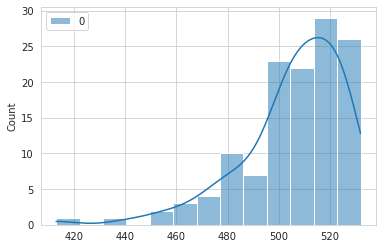

In [5]:
atlas_kmeans_eroded = np.zeros_like(parcellation['atlas_kmeans'])

radius = 5
for region_id, ctr in parcellation['cluster_centers'].items():
    for voxel in list(zip(*np.where(parcellation['atlas_kmeans'] == region_id))):
        dist = np.linalg.norm(ctr - voxel)
        if dist < radius:
            atlas_kmeans_eroded[voxel] = region_id

# report
x = atlas_kmeans_eroded.copy().astype(float)
num_region_voxels = {}
for region_id in np.unique(x[x > 0]):
    num_region_voxels[region_id] = (x == region_id).sum()

sns.set_style('whitegrid')
sns.histplot(num_region_voxels.values(), kde=True)
plt.show()

In [6]:
selected_names = [
    'Striatum',
    'Pallidum',
    'Olfactory areas',
    'Cortical subplate',
    'Hippocampal formation',
    'Isocortex',
]

root_mask_l, root_mask_r = mask_left_right(allen['root_mask'])
selected_structures = allen['structure_tree'].get_structures_by_name(selected_names)

roi_masks = {}
for structure_dict in selected_structures:
    print('id: {:d},\tname: {:s}'.format(structure_dict['id'], structure_dict['name']))
    if structure_dict['name'] == 'Isocortex':
        for region_id_l in range(1, num_regions+1):
            region_id_r = region_id_l + num_regions
            _mask_l = atlas_kmeans_eroded == region_id_l
            _mask_r = atlas_kmeans_eroded == region_id_r
            roi_masks['0-{:d}-{:d}'.format(structure_dict['id'], region_id_l)] = _mask_l.astype(bool)
            roi_masks['1-{:d}-{:d}'.format(structure_dict['id'], region_id_r)] = _mask_r.astype(bool)
    else:
        _mask = allen['mcc'].get_structure_mask(structure_dict['id'])[0]
        _mask_l = np.logical_and(_mask, root_mask_l)
        _mask_r = np.logical_and(_mask, root_mask_r)
        roi_masks['0-{:d}'.format(structure_dict['id'])] = _mask_l.astype(bool)
        roi_masks['1-{:d}'.format(structure_dict['id'])] = _mask_r.astype(bool)

id: 477,        name: Striatum

id: 803,        name: Pallidum

id: 698,        name: Olfactory areas

id: 703,        name: Cortical subplate

id: 1089,       name: Hippocampal formation

id: 315,        name: Isocortex

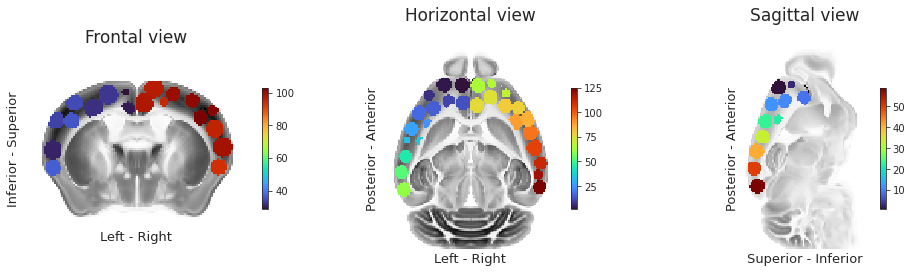

In [7]:
fig, axes = create_figure(1, 3, figsize=(13, 3.9))

slice_idxs = [58, 30, 44]
for i, (ax, plane, labels) in enumerate(zip(axes, atlas.space.sections, atlas.space.axis_labels)):
    data2plt = atlas_kmeans_eroded.take(slice_idxs[i], axis=i)
    data2plt = np.ma.masked_where(data2plt == 0, data2plt)
    ax.imshow(atlas.reference.take(slice_idxs[i], axis=i), cmap='Greys')
    im = ax.imshow(data2plt, cmap='turbo')
    plt.colorbar(im, ax=ax, shrink=0.6)
    
    ax.set_title(f"{plane.capitalize()} view\n", fontsize=17)
    ax.set_ylabel(labels[0], fontsize=13)
    ax.set_xlabel(labels[1], fontsize=13)

    _ = list(map(lambda x: x.set_visible(False), ax.spines.values()))
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

## Custom colors!

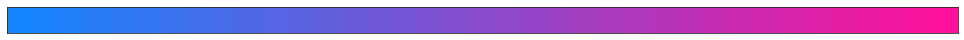

In [8]:
_ = make_cmap(['#1486ff', '#ff119b'])

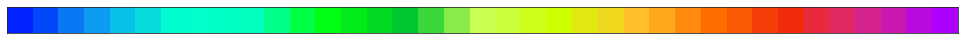

In [9]:
n_colors = num_regions * 2
ramp_colors = [
    '#0023ff', '#0ea4f1', '#00ffcf', '#00ffc1',
    '#00ff0d', '#00c72e', '#caff58',
    '#cfff00', '#ffc22c', '#ff7200',
    '#f42c0b', '#d82789', '#ad00ff',
]

custom_cmap = make_cmap(
    ramp_colors=ramp_colors,
    name='parcellation_cmap',
    n_colors=n_colors,
)

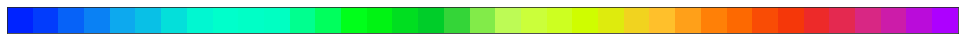

In [10]:
custom_cmap.set_gamma(1.1)
display_cmap(custom_cmap, len(ramp_colors))

## Render cortical ROIs

In [11]:
_ = parcel2html(
    parcel=atlas_kmeans_eroded,
    save_dir=extras_dir,
    cmap=custom_cmap,
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/parcel128_parcellation_cmap.html

In [12]:
_ = parcel2html(
    parcel=atlas_kmeans_eroded,
    save_dir=extras_dir,
    cmap='nipy_spectral',
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/parcel128_nipy_spectral.html

### Embed result

In [6]:
path = f"../../_extras/parcel-128_cmap-custom.html"
display(IFrame(path, width=1000, height=700))

In [7]:
n_clusters = 4
path = f"../../_extras/cluster3d-canberra_parcel-128_n-{n_clusters}.html"
display(IFrame(path, width=1000, height=700))

In [8]:
n_clusters = 14
path = f"../../_extras/cluster3d-canberra_parcel-128_n-{n_clusters}.html"
display(IFrame(path, width=1000, height=700))

## Add streamlines

In [16]:
_ = tracts2html('RSP', other_regions=['SS', 'MOp', 'MOs'], save_dir=extras_dir)
_ = tracts2html('ORB', other_regions=['SS', 'MO'], save_dir=extras_dir)
_ = tracts2html('SS', other_regions=['ORB', 'MO'], save_dir=extras_dir)

Output()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/streams_RSP.html

Output()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/streams_ORB.html

Output()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/streams_SS.html

### Embed

In [9]:
path = f"../../_extras/streams-RSP.html"
display(IFrame(path, width=1000, height=700))

In [10]:
path = f"../../_extras/streams-ORB.html"
display(IFrame(path, width=1000, height=700))

In [11]:
path = f"../../_extras/streams-SS.html"
display(IFrame(path, width=1000, height=700))

## Report properties of a parcellation (TODO)
use:

import pyinspect as pi

In [ ]:
    def content(self):
        """
        Prints an overview of the Actors in the scene.
        """

        actors = pi.Report(
            "Scene actors", accent=salmon, dim=orange, color=orange
        )

        for act in self.actors:
            actors.add(
                f"[bold][{amber}]- {act.name}[/bold][{orange_darker}] "
                f"(type: [{orange}]{act.br_class}[/{orange}]) "
                f"(color: [{orange}]{rgb2hex(act.mesh.c())}[/{orange}]) "
                f"(alpha: [{orange}]{act.mesh.alpha()}[/{orange}]) "
            )

        if "win32" != sys.platform:
            actors.print()
        else:
            print(pi.utils.stringify(actors, maxlen=-1))